# Time-resolved pupil analysis

## set-up

### imports

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache

# REPO_PATH = 'C:/Users/User/visual_encoding'
DATA_DIRECTORY = r'E:\datasets\allen_vc' #f'E:/datasets/allen_vc/manifest_files'

import sys
sys.path.append('../../')
from allen_vc.epoch_extraction_tools import *
from allen_vc.plots import plot_epochs

print('Packages Imported')

Packages Imported


### settings

In [5]:
# settings
PF = 50
KERNEL_SIZE = 1*PF

## load and pre-processs example pupil data

In [6]:
manifest_path = os.path.join(DATA_DIRECTORY, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
sessions = cache.get_session_table()
sessions = sessions[sessions.get('session_type')=='functional_connectivity']
sessions.head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
766640955,2019-10-03T00:00:00Z,744912849,functional_connectivity,133.0,M,wt/wt,842,2233,6,"[MB, APN, NOT, DG, CA1, VISam, nan, PF, TH, LP..."
767871931,2019-10-03T00:00:00Z,753795610,functional_connectivity,135.0,M,wt/wt,713,2231,6,"[MRN, APN, MB, DG, CA1, VISrl, nan, VISam, PO,..."
768515987,2019-10-03T00:00:00Z,754477358,functional_connectivity,136.0,M,wt/wt,802,2217,6,"[MB, APN, NOT, DG, CA1, VISam, nan, Eth, LP, P..."
771160300,2019-10-03T00:00:00Z,754488979,functional_connectivity,142.0,M,wt/wt,930,2230,6,"[SCig, PPT, NOT, SUB, ProS, CA1, VISam, nan, A..."
771990200,2019-10-03T00:00:00Z,756578435,functional_connectivity,108.0,M,wt/wt,546,2229,6,"[APN, MB, DG, CA1, VISam, nan, PO, LP, VISpm, ..."


In [7]:
# import example pupil data
SESSION_ID = 766640955
session = cache.get_session_data(SESSION_ID)
pupil_data = session.get_screen_gaze_data()
pupil_data.head()

,raw_eye_area,raw_pupil_area,raw_screen_coordinates_x_cm,raw_screen_coordinates_y_cm,raw_screen_coordinates_spherical_x_deg,raw_screen_coordinates_spherical_y_deg
Time (s),,,,,,
3.16310,0.058795,0.011054,3.969006,-1.626442,14.739801,-6.189063
3.19620,0.058669,0.011164,4.001801,-1.664556,14.852316,-6.332932
3.21337,0.058594,0.011342,4.086463,-1.686111,15.149932,-6.414260
3.24650,0.058705,0.011354,4.085960,-1.687487,15.148002,-6.419451
3.27980,0.058736,0.011374,4.101932,-1.634886,15.210047,-6.220944


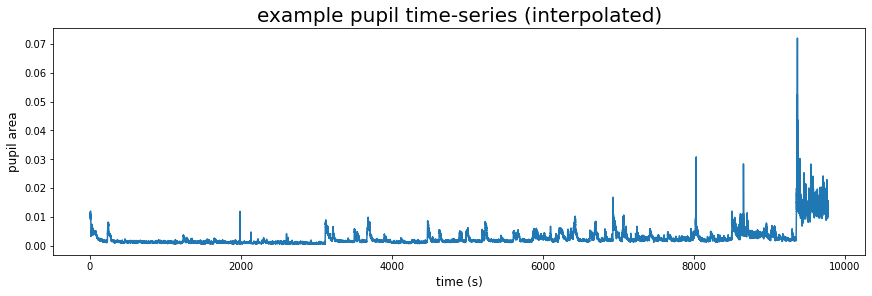

In [13]:
# interpolate pupil data
pupil_data = pupil_data[pupil_data['raw_pupil_area'].notna()]
values = pupil_data['raw_pupil_area']
time_points = pupil_data.index

#Create uniform set of data using interpolation
model = interpolate.interp1d(time_points, values)
time = np.arange(time_points[0], time_points[-1], 1/PF)
area = model(time)

# plot
fig, ax = plt.subplots(1,1, figsize=[12,4])
ax.plot(time, area)
ax.set(xlabel="time (s)", ylabel="pupil area")
ax.set_title("example pupil time-series (interpolated)")
plt.show()

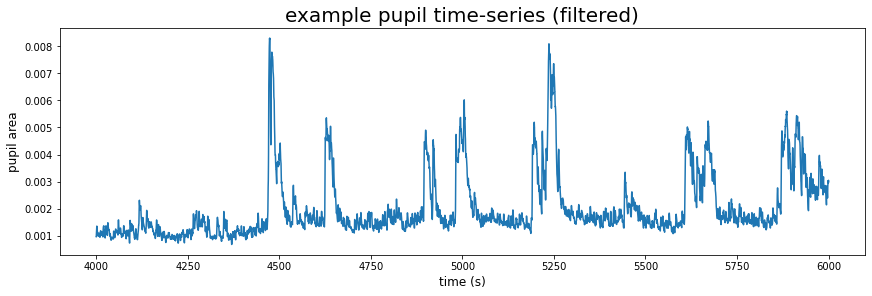

In [12]:
# apply median filter to pupil data
from scipy.ndimage import median_filter

stim_pupil_area = area[(time > 4000) & (time < 6000)] # approx time of spontaneous block
stim_time = time[(time > 4000) & (time < 6000)]
stim_pupil_filt = median_filter(stim_pupil_area, KERNEL_SIZE)

# plot
fig, ax = plt.subplots(1,1, figsize=[12,4])
ax.plot(stim_time, stim_pupil_filt);
ax.set(xlabel="time (s)", ylabel="pupil area")
ax.set_title("example pupil time-series (filtered)")
plt.show()

## epoch pupil data

### dialating v constricting

In [14]:
# settings for epoching (found based on experimentation in epoch_counts.ipynb)
ABOVE_THRESHOLD = 0.0000025
BELOW_THRESHOLD = -0.0000001
MIN_GAP = 0.05
ABOVE_MIN_DURATION = 0.5
BELOW_MIN_DURATION = 2

Signal Start: 4397.968316906174 s


Identified 4912 epochs
Joined 2205 / 4912 epochs
Joined 3837 / 4913 epochs
Dropped 2617 / 2707 epochs
Dropped 641 / 1076 epochs
Identified 3548 epochs
Joined 612 / 3548 epochs
Joined 2004 / 3548 epochs
Dropped 2863 / 2936 epochs
Dropped 1470 / 1544 epochs
Found 90 Above Epochs and 74 Below Epochs



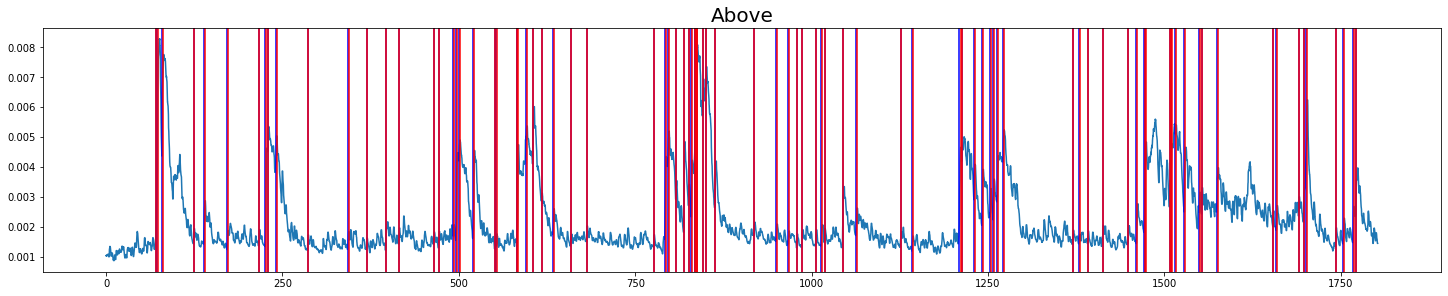

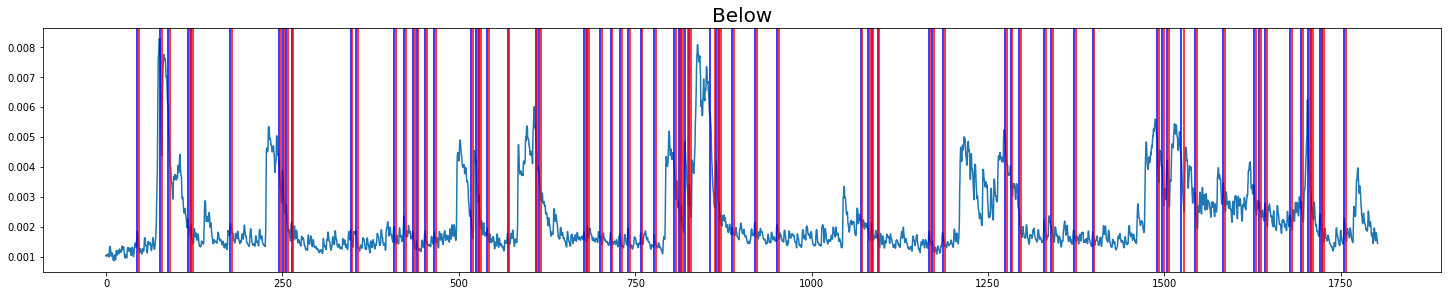

In [15]:
group = pd.read_pickle(f"G:/Shared drives/visual_encoding/data/behavior/pupil/spontaneous/pupil_area_{SESSION_ID}.pkl")
sig =  group.analogsignals[4]
print(f"Signal Start: {sig.t_start}\n\n")
area_deriv = np.diff(sig.magnitude.T[0])
above, _ = get_epoch_times(area_deriv, ABOVE_THRESHOLD, MIN_GAP, ABOVE_MIN_DURATION, PF)
_, below = get_epoch_times(area_deriv, BELOW_THRESHOLD, MIN_GAP, BELOW_MIN_DURATION, PF)

print(f'Found {len(above)} Above Epochs and {len(below)} Below Epochs\n')

plot_epochs(sig.magnitude.T[0], np.arange(0, len(sig.magnitude.T[0]))/PF, above)
plt.title("Above")

plot_epochs(sig.magnitude.T[0], np.arange(0, len(sig.magnitude.T[0]))/PF, below)
plt.title("Below");

In [16]:
# average length of above epochs (dilation)
np.mean(above[:,1] - above[:,0])

0.8295555555555593

In [17]:
# average length of below epochs (constriction)
np.mean(below[:,1] - below[:,0])

2.628648648648637

In [18]:
above_split = split_epochs(above, 0.7)
below_split = split_epochs(below, 2)

### high arounsal v low arousal

In [36]:
# settings for epoching 
MIN_GAP = 1
MIN_DURATION = 30

Signal Start: 4397.968316906174 s


Identified 46 epochs
Joined 12 / 46 epochs
Joined 6 / 47 epochs
Dropped 26 / 34 epochs
Dropped 32 / 41 epochs
Found 8 Above Epochs and 9 Below Epochs



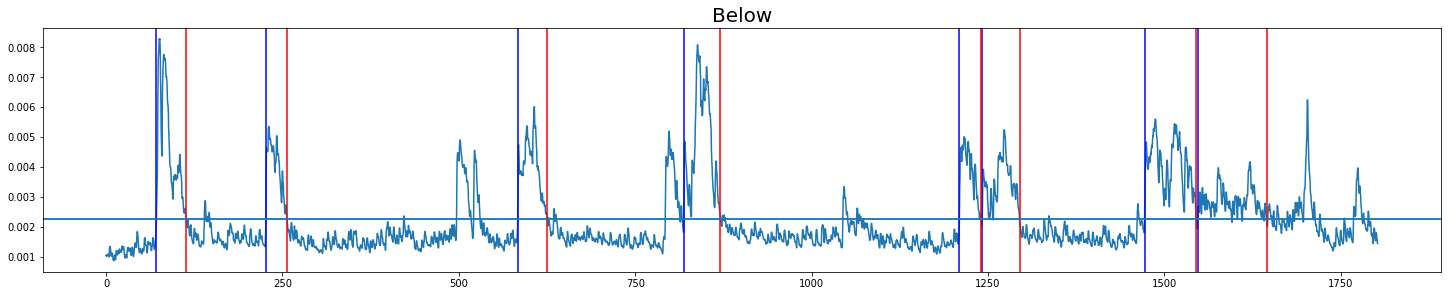

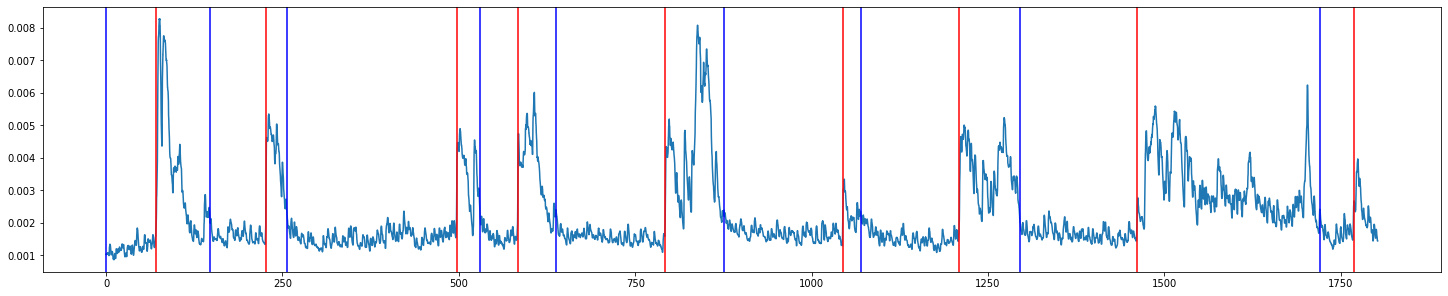

In [37]:
# get example signal
group = pd.read_pickle(f"G:/Shared drives/visual_encoding/data/behavior/pupil/spontaneous/pupil_area_{SESSION_ID}.pkl")
sig =  group.analogsignals[4]
print(f"Signal Start: {sig.t_start}\n\n")

# set params
thresh = np.mean(sig) #+ (1 * np.std(sig))

# epoch
above, below = get_epoch_times(sig, thresh, MIN_GAP, MIN_DURATION, PF)

print(f'Found {len(above)} Above Epochs and {len(below)} Below Epochs\n')

plot_epochs(sig.magnitude.T[0], np.arange(0, len(sig.magnitude.T[0]))/PF, above)
ax = plt.gca()
ax.axhline(thresh)
ax.set_title("Above")

plot_epochs(sig.magnitude.T[0], np.arange(0, len(sig.magnitude.T[0]))/PF, below)
ax.axhline(thresh)
ax.set_title("Below");

## Time-resolved FFT of LFP to extract parameters for shorter epochs

In [38]:
from allen_vc.allen_utils import find_probes_in_region, align_lfp

In [39]:
probe_id = find_probes_in_region(session, 'VISp')[0][0]
lfp = session.get_lfp(probe_id)

In [40]:
chan_ids = session.channels[(session.channels.probe_id==probe_id) & \
                    (session.channels.ecephys_structure_acronym=='VISp')].index.values

In [41]:
lfp_spont = lfp.sel(time=slice(4000, 6000)).sel(channel=slice(np.min(chan_ids), np.max(chan_ids)))
lfp_spont

<xarray.DataArray 'LFP' (time: 2499999, channel: 22)>
array([[ 3.51195e-04,  4.02285e-04,  3.41640e-04, ...,  2.53500e-05,
         9.55500e-06, -1.07250e-05],
       [ 3.55875e-04,  3.98970e-04,  3.25845e-04, ...,  2.24250e-05,
         7.99500e-06, -1.15050e-05],
       [ 3.61140e-04,  3.97995e-04,  3.41250e-04, ...,  2.04750e-05,
         7.99500e-06, -1.44300e-05],
       ...,
       [-2.76900e-05, -3.62700e-05, -5.03100e-05, ...,  2.73000e-06,
         0.00000e+00,  6.24000e-06],
       [-4.48500e-05, -4.95300e-05, -5.81100e-05, ..., -3.51000e-06,
         2.73000e-06,  0.00000e+00],
       [-4.17300e-05, -4.27050e-05, -6.76650e-05, ..., -5.46000e-06,
         3.31500e-06,  1.75500e-06]], dtype=float32)
Coordinates:
  * time     (time) float64 4e+03 4e+03 4e+03 4e+03 ... 6e+03 6e+03 6e+03 6e+03
  * channel  (channel) int64 850025318 850025326 ... 850025478 850025486

In [42]:
raw_lfp = lfp_spont.values
lfp_swapped = np.swapaxes(raw_lfp, 0 ,1)

In [44]:
# now we do time resolved fft!
import mne.time_frequency as mtf
from time import time as timer

In [ ]:
# choose random time frame for experimentation
lfp_cropped = lfp_swapped[:,:10000]

In [ ]:
t_start = timer()
psd = mtf.tfr_array_multitaper(np.array([lfp_cropped]),sfreq=1250,freqs=np.arange(1,30), output='power', verbose=True)
print(timer() - t_start)

1.4261701107025146


In [26]:
psd.shape # (n_epochs, n_chans, n_freqs, n_times)

(1, 22, 29, 10000)

In [27]:
import seaborn as sns

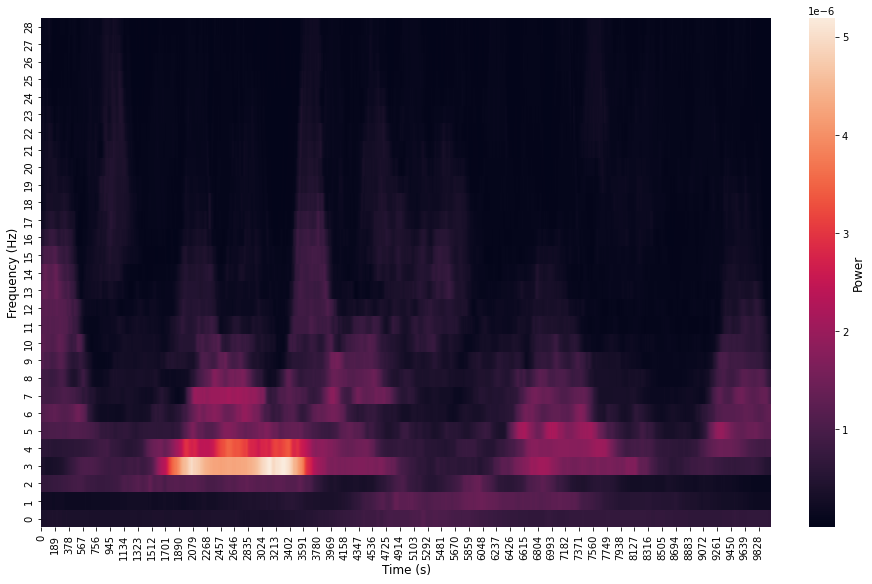

In [28]:
plt.figure(figsize=(12,8))
ax = sns.heatmap(psd[0,0,:,:], cbar_kws={'label': 'Power'});
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)');
ax.invert_yaxis()

In [ ]:
# now perform the analyses for every constriction/dilation epoch

In [59]:
# form arrays including each epoch

lfp_epochs = []

for epoch in (np.array(above_split) + float(sig.t_start)):
    
    lfp_epochs.append(lfp.sel(time=slice(epoch[0], 
                    epoch[1])).sel(channel=slice(np.min(chan_ids), 
                    np.max(chan_ids))).values)

above_lfp_epoched = np.swapaxes(np.array(lfp_epochs),1,2)

lfp_epochs = []

for epoch in (np.array(below_split) + float(sig.t_start)):
    
    lfp_epochs.append(lfp.sel(time=slice(epoch[0], 
                    epoch[1])).sel(channel=slice(np.min(chan_ids), 
                    np.max(chan_ids))).values)
    
below_lfp_epoched = np.swapaxes(np.array(lfp_epochs),1,2)

In [67]:
# 875 time points for above, 2500 for below (limits frequency range that can be observed)

above_lfp_epoched.shape, below_lfp_epoched.shape

((60, 22, 875), (77, 22, 2500))

In [84]:
# 
freq_range = np.arange(10,100)

dilation_mt = mtf.tfr_array_multitaper(above_lfp_epoched,sfreq=1250,freqs=freq_range, output='power', verbose=True)
constriction_mt = mtf.tfr_array_multitaper(below_lfp_epoched,sfreq=1250,freqs=freq_range, output='power', verbose=True)

In [85]:
dilation_mt.shape # epoch, channel, freqs, time points

(60, 22, 90, 875)

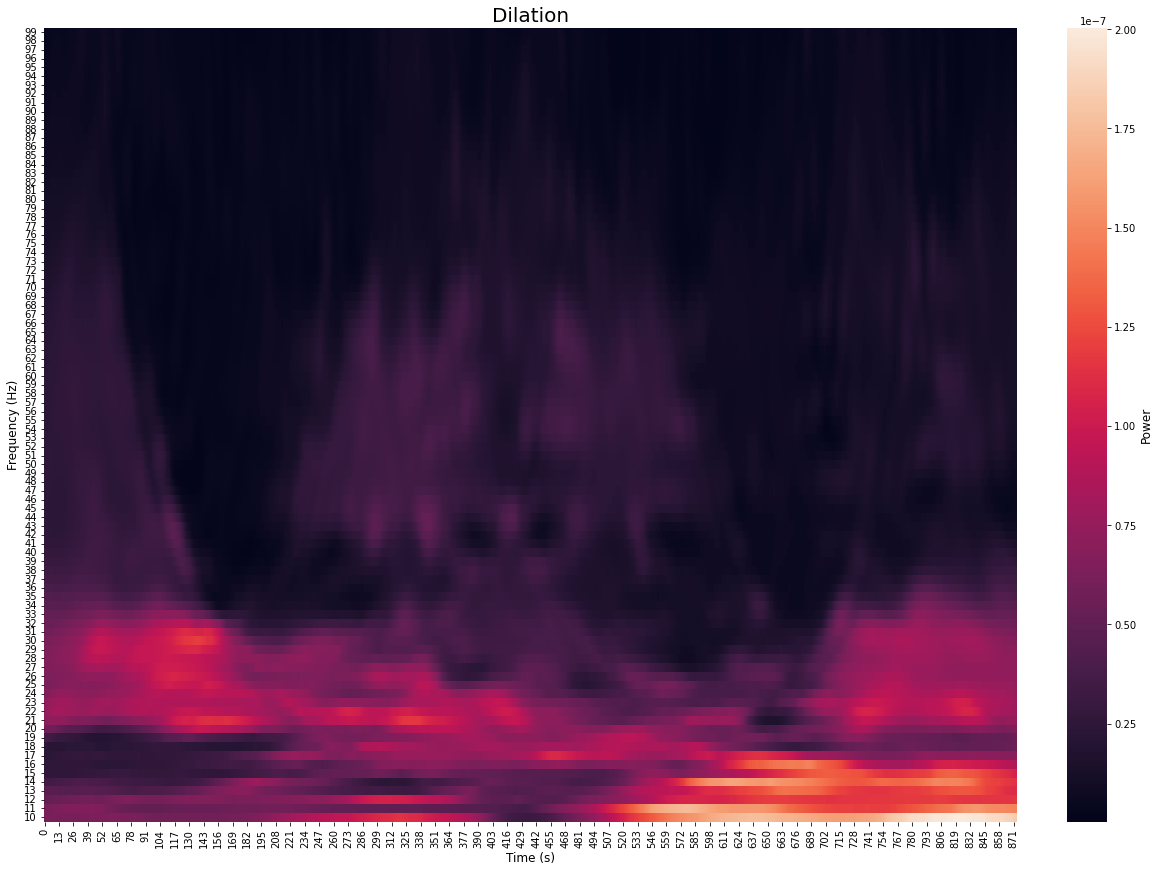

In [100]:
# look at an arbitrary dilation vs constriction epoch

plt.figure(figsize=(16,12))
ax = sns.heatmap(dilation_mt[20,0,:,:], cbar_kws={'label': 'Power'}, yticklabels=freq_range)
plt.title('Dilation')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
ax.invert_yaxis();

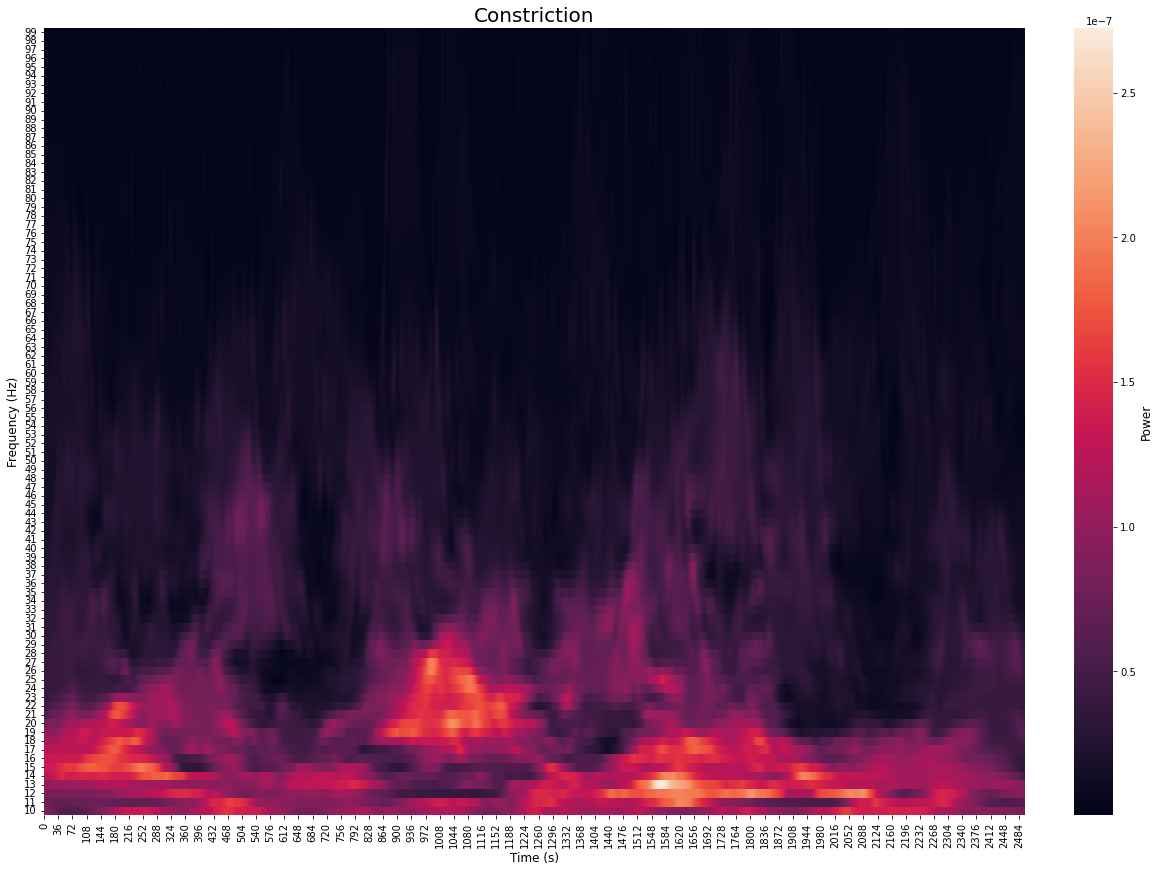

In [98]:
plt.figure(figsize=(16,12))
ax = sns.heatmap(constriction_mt[20,0,:,:], cbar_kws={'label': 'Power'}, yticklabels=freq_range)
plt.title('Constriction')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
ax.invert_yaxis();

# LFP Parameter Temporal Correlations

In [5]:
# settings
# REPO = 'C:/Users/User/visual_encoding'
DATA = 'G:/Shared drives/visual_encoding/data'

In [80]:
import pandas as pd
import numpy as np
import neo
import quantities as pq
import matplotlib.pyplot as plt
import sys
import os
from time import time as timer
sys.path.append('../..')

from allen_vc.plots import plot_linregress, sync_plot

print("Packages Imported")

Packages Imported


In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# concatenate param data
dfs = []
for file in os.listdir(f'{DATA}/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/by_session'):
    dfs.append(pd.read_csv(f'{DATA}/lfp_data/params/tfr/natural_movie_one_more_repeats/knee/by_session/{file}'))

all_chans = pd.concat(dfs)

In [44]:
all_chans.head()

,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,bw_1,cf_2,...,bw_2,cf_3,pw_3,bw_3,error,r_squared,chan_idx,epoch_idx,window_idx,session
0,-5.098292,50.551809,2.392293,43.427308,1.575758,3.265129,61.989175,1.252601,20.000000,79.503650,...,2.00000,103.419348,1.311975,20.000000,0.470159,0.727027,0,1,0,794812542
1,-5.171065,283.439458,2.301310,6.376552,1.454528,4.133827,61.989174,1.173728,20.000000,79.559116,...,2.00000,126.435563,0.920040,20.000000,0.347419,0.823777,1,1,0,794812542
2,-4.554493,199.083903,2.593378,79.433338,1.429337,2.000000,98.682195,1.197455,13.648457,115.411423,...,6.05373,127.624511,1.479034,6.385413,0.510081,0.756731,2,1,0,794812542
3,-5.881236,19.093443,1.797269,6.289776,1.292819,3.963402,32.109058,1.190631,4.871598,97.419348,...,20.00000,124.693503,0.798353,12.745388,0.265532,0.888358,3,1,0,794812542
4,-6.146080,8.283787,1.637227,6.077197,1.382723,3.749355,32.168814,1.268841,5.315472,74.907842,...,20.00000,103.419348,0.861539,20.000000,0.319424,0.837117,4,1,0,794812542


In [90]:
# median across channels
params = all_chans.groupby(['session', 'epoch_idx', 'window_idx']).median().drop(['chan_idx'], axis=1).reset_index()

In [46]:
params.head()

,session,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,bw_1,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared
0,766640955,1,0,-4.115208,9.968530,2.423561,64.467576,1.233282,9.732393,94.041406,1.385570,3.384751,118.799761,1.332603,5.113630,132.435563,1.289509,10.118157,0.330113,0.885538
1,766640955,1,1,-3.954905,11.661401,2.582745,63.642010,1.232250,7.163074,99.365796,1.274334,3.202332,118.969208,1.249717,5.786398,131.225242,1.119601,11.121559,0.320669,0.891436
2,766640955,1,2,-3.810811,7.437185,2.646690,61.905297,1.044139,19.982444,114.950307,1.235087,7.364720,122.320409,1.268337,7.544635,132.205563,1.122866,10.364844,0.302633,0.903953
3,766640955,1,3,-3.675141,9.884550,2.679084,61.592062,1.109199,5.776820,73.793539,1.214822,8.454238,118.174816,1.244945,12.379198,132.435563,1.193891,11.217565,0.304857,0.901293
4,766640955,1,4,-3.742768,9.195486,2.637796,49.367178,1.149908,5.723401,74.629031,1.201398,7.115478,118.733133,1.198596,6.158769,131.744733,1.130073,12.123564,0.318002,0.898060


In [54]:
# now let's add instantaneous spike rate data and pupil area data

In [64]:
# initialize arrays for storage
inst_spike_rate = np.array([])
avg_pupil_area = np.array([])

# use sliding window with same window size used for param calculation
window_size = 0.02*pq.s

start = timer()

for ses_id in params['session'].unique():
    print(f"Computing session: {ses_id}")
    block = neo.io.NeoMatlabIO(f'{DATA}/blocks/segmented/natural_movie_one_more_repeats/block_{ses_id}.mat').read_block()
    seg = block.segments[0]
    
    seg_rates = np.empty((len(seg.spiketrains),0))
    seg_pupil_area = []
    i = seg.annotations['stimulus_onset']*pq.s
    
    # loop over sliding window
    while i <= seg.t_stop - window_size:
        
        # calculate average pupil area over window
        if len(seg.analogsignals) > 1:
            seg_pupil_area.append(np.mean(seg.analogsignals[1].time_slice(i, i+window_size)))
        else:
            seg_pupil_area.append(np.nan)
        
        # calculate spike train rates for each unit over window
        train_rates = []
        for train in seg.spiketrains:
            train_rates.append(np.sum(train.time_slice(i, i+window_size) > 0)/window_size)
        seg_rates = np.hstack((seg_rates, np.array([train_rates]).T))
        
        i += window_size
        
    # add segment data to total array
    avg_pupil_area = np.append(avg_pupil_area, seg_pupil_area)
    inst_spike_rate = np.append(inst_spike_rate, np.mean(seg_rates, axis=0))
    
    
print(f'Total Time: {timer() - start}')

Computing session: 766640955
Computing session: 767871931
Computing session: 768515987
Computing session: 771160300
Computing session: 771990200
Computing session: 774875821
Computing session: 778240327
Computing session: 778998620
Computing session: 779839471
Computing session: 781842082
Computing session: 786091066
Computing session: 787025148
Computing session: 789848216
Computing session: 793224716
Computing session: 794812542
Computing session: 816200189
Computing session: 821695405
Computing session: 829720705
Computing session: 831882777
Computing session: 835479236
Computing session: 839068429
Computing session: 840012044
Computing session: 847657808
Total Time: 1152.695524930954


In [65]:
avg_pupil_area.shape

(34500,)

In [66]:
inst_spike_rate.shape

(34500,)

In [91]:
params['inst_spike_rate'] = inst_spike_rate
params['avg_pupil_area'] = avg_pupil_area

params.head()

,session,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,...,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared,inst_spike_rate,avg_pupil_area
0,766640955,1,0,-4.115208,9.968530,2.423561,64.467576,1.233282,9.732393,94.041406,...,118.799761,1.332603,5.113630,132.435563,1.289509,10.118157,0.330113,0.885538,6.640625,0.002671
1,766640955,1,1,-3.954905,11.661401,2.582745,63.642010,1.232250,7.163074,99.365796,...,118.969208,1.249717,5.786398,131.225242,1.119601,11.121559,0.320669,0.891436,7.812500,0.002669
2,766640955,1,2,-3.810811,7.437185,2.646690,61.905297,1.044139,19.982444,114.950307,...,122.320409,1.268337,7.544635,132.205563,1.122866,10.364844,0.302633,0.903953,12.109375,0.002682
3,766640955,1,3,-3.675141,9.884550,2.679084,61.592062,1.109199,5.776820,73.793539,...,118.174816,1.244945,12.379198,132.435563,1.193891,11.217565,0.304857,0.901293,9.765625,0.002681
4,766640955,1,4,-3.742768,9.195486,2.637796,49.367178,1.149908,5.723401,74.629031,...,118.733133,1.198596,6.158769,131.744733,1.130073,12.123564,0.318002,0.898060,9.765625,0.002670


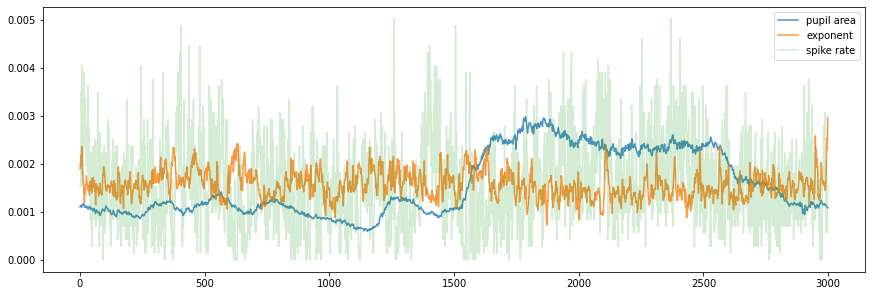

In [70]:
# plot time-series

# scale vars for visualization
exponent_scaled = params['exponent'] / np.mean(params['exponent']) * np.mean(params['avg_pupil_area'])
rate_scaled = params['inst_spike_rate'] / np.mean(params['inst_spike_rate']) * np.mean(params['avg_pupil_area'])

# plot
fig, ax = plt.subplots(1,1, figsize=[12,4])
ax.plot(params['avg_pupil_area'], alpha=0.8, label='pupil area')
ax.plot(exponent_scaled, alpha=0.8, label='exponent')
ax.plot(rate_scaled, alpha=0.2, label='spike rate')
ax.set(xlabel="", ylabel="")
ax.set_title("")
ax.legend()
plt.show()

In [92]:
full_params = params.dropna(axis=0,subset=['avg_pupil_area', 'inst_spike_rate'])

<AxesSubplot:ylabel='Density'>

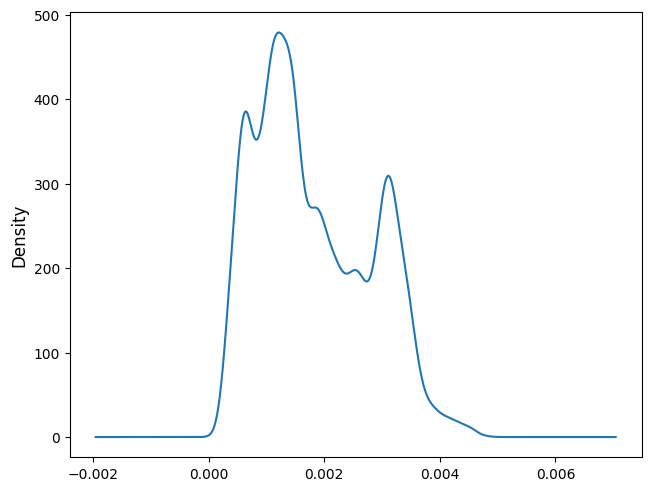

In [93]:
full_params['avg_pupil_area'].plot(kind='kde')

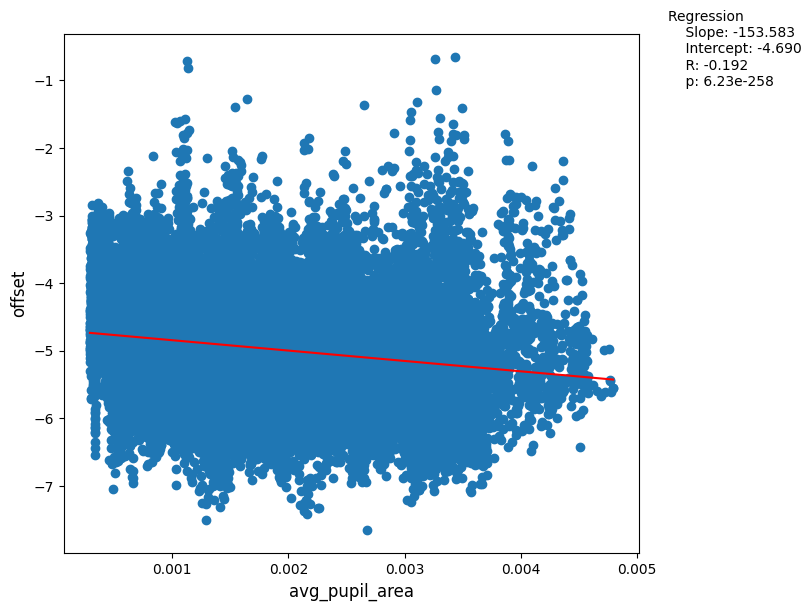

In [94]:
plot_linregress(full_params, 'avg_pupil_area', 'offset', show=True) 

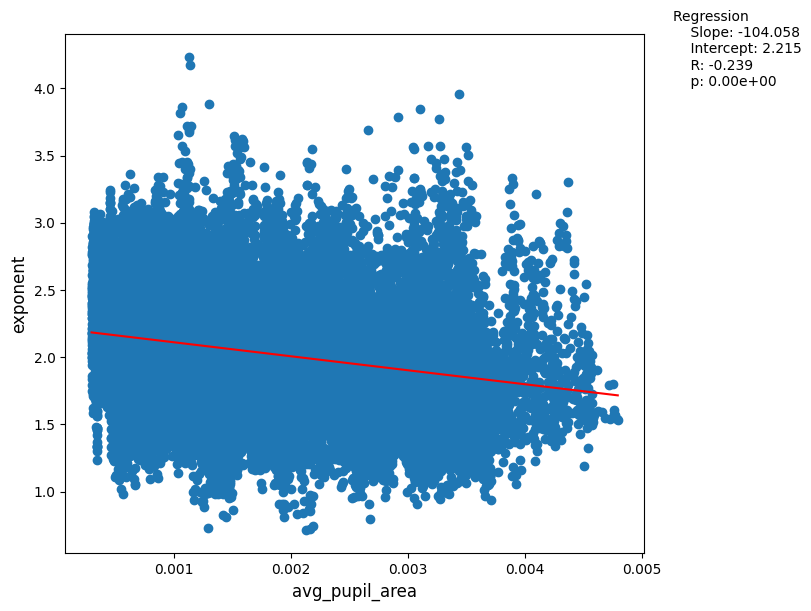

In [95]:
plot_linregress(full_params, 'avg_pupil_area', 'exponent', show=True) 

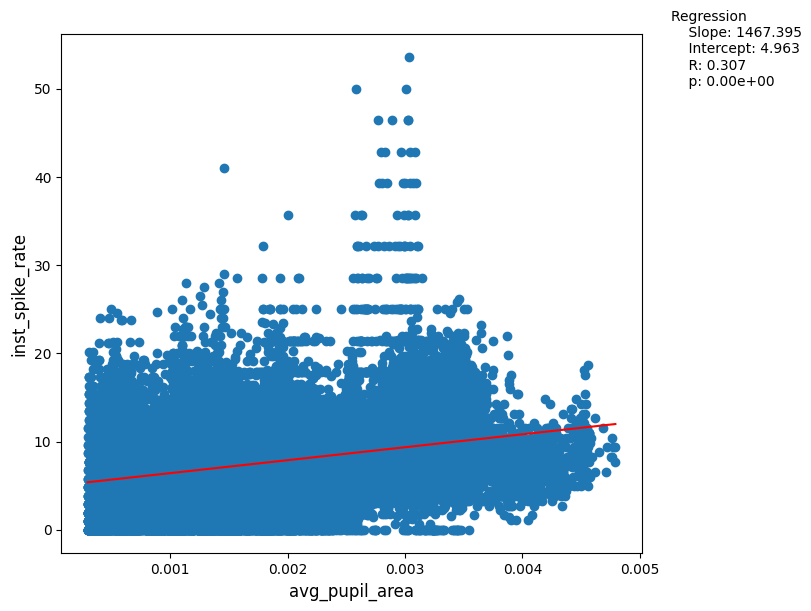

In [96]:
plot_linregress(full_params, 'avg_pupil_area', 'inst_spike_rate', show=True) 

##  Fit Evaluation

In [100]:
knee = params[params['window_idx'] < 30].assign(fit='knee').drop(['avg_pupil_area', 'inst_spike_rate'], axis=1)
fixed = pd.read_csv(f'{DATA}/lfp_data/params/tfr/natural_movie_one_more_repeats/fixed/lfp_params.csv').groupby(['session','epoch_idx','window_idx']).median().reset_index().assign(fit='fixed')
all_fits = pd.concat([knee, fixed])

In [103]:
all_fits

,session,epoch_idx,window_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,...,cf_2,pw_2,bw_2,cf_3,pw_3,bw_3,error,r_squared,fit,chan_idx
0,766640955,1,0,-4.115208,9.968530,2.423561,64.467576,1.233282,9.732393,94.041406,...,118.799761,1.332603,5.113630,132.435563,1.289509,10.118157,0.330113,0.885538,knee,NaN
1,766640955,1,1,-3.954905,11.661401,2.582745,63.642010,1.232250,7.163074,99.365796,...,118.969208,1.249717,5.786398,131.225242,1.119601,11.121559,0.320669,0.891436,knee,NaN
2,766640955,1,2,-3.810811,7.437185,2.646690,61.905297,1.044139,19.982444,114.950307,...,122.320409,1.268337,7.544635,132.205563,1.122866,10.364844,0.302633,0.903953,knee,NaN
3,766640955,1,3,-3.675141,9.884550,2.679084,61.592062,1.109199,5.776820,73.793539,...,118.174816,1.244945,12.379198,132.435563,1.193891,11.217565,0.304857,0.901293,knee,NaN
4,766640955,1,4,-3.742768,9.195486,2.637796,49.367178,1.149908,5.723401,74.629031,...,118.733133,1.198596,6.158769,131.744733,1.130073,12.123564,0.318002,0.898060,knee,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,847657808,1,25,-6.082858,NaN,1.543109,18.942700,1.298790,4.421376,26.379876,...,34.290440,1.266884,3.754174,53.367021,0.922188,16.458379,0.345899,0.811023,fixed,11.5
686,847657808,1,26,-5.987714,NaN,1.497439,16.425271,1.251212,15.255162,20.544861,...,32.289612,1.088699,2.078898,60.159276,1.157189,3.203915,0.339052,0.820146,fixed,11.5
687,847657808,1,27,-5.948333,NaN,1.536940,11.591358,1.153485,7.024935,19.405746,...,32.267412,1.217111,2.711533,53.420227,0.954151,13.874355,0.359464,0.812700,fixed,11.5
688,847657808,1,28,-5.696392,NaN,1.738964,11.773245,1.364834,2.725553,23.349179,...,34.269950,1.076285,6.123488,65.096474,1.155888,11.100472,0.364659,0.824300,fixed,11.5


In [107]:
import seaborn as sns

In [108]:
metrics = ['error', 'r_squared']

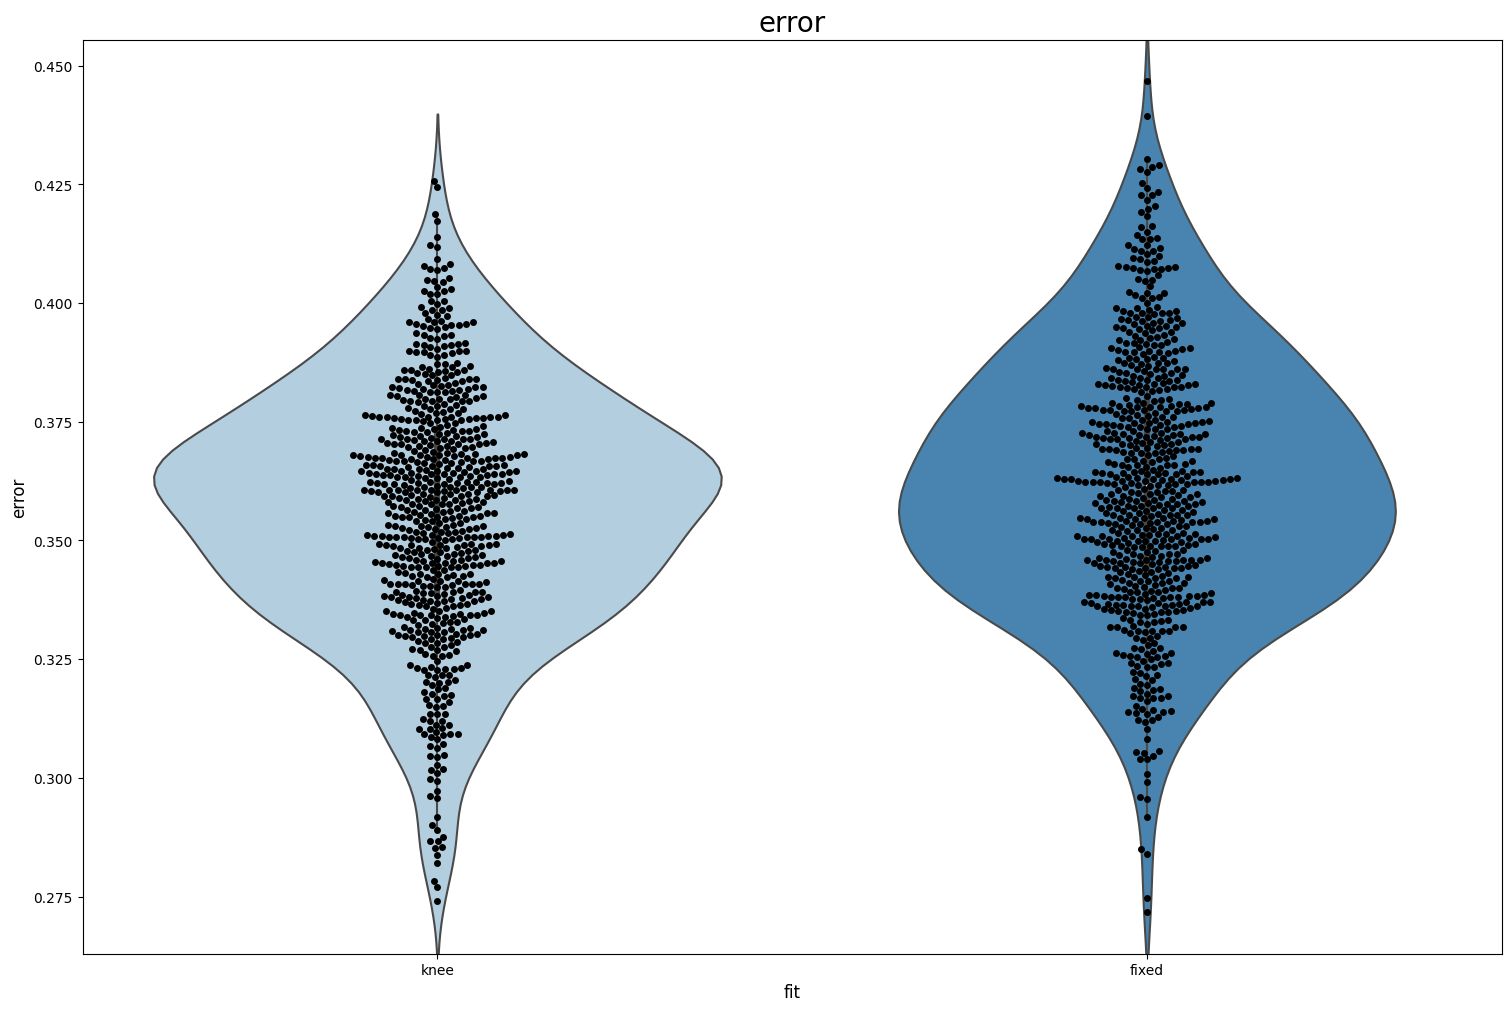

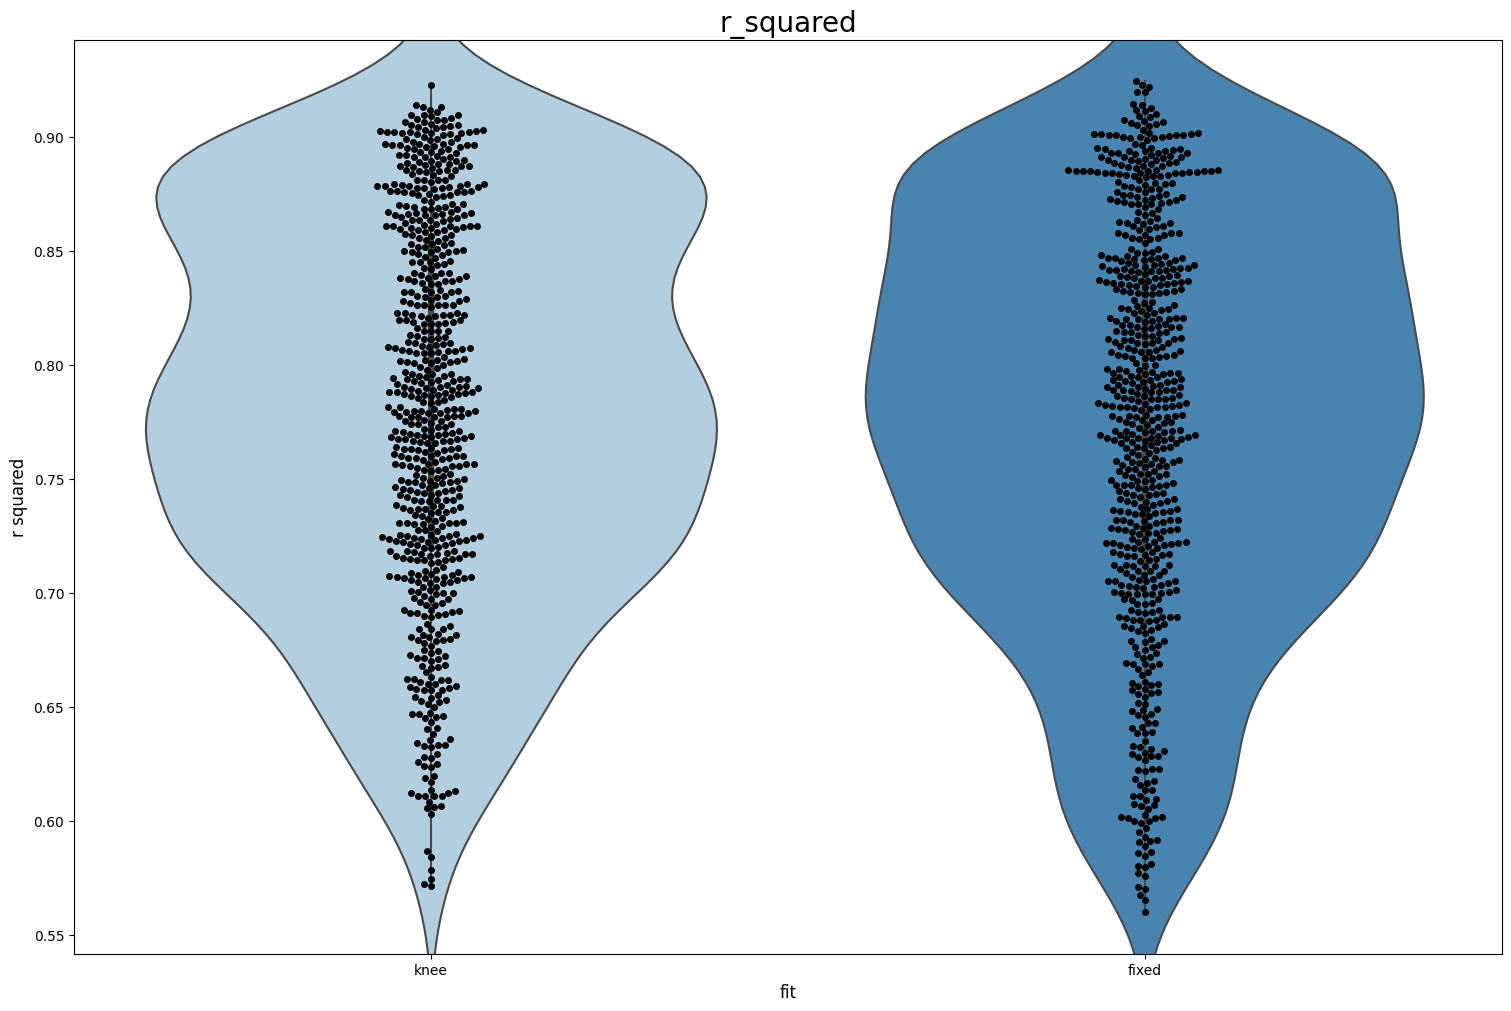

In [110]:
for metric in metrics:
    # set plotting parameters
    plotting_params = {
        'data':    all_fits,
        'x':       'fit',
        'y':       metric,
    }

    # create figure
    fig, ax = plt.subplots(figsize=(15,10))
    plt.title(f'{metric}')
    vp = sns.violinplot(**plotting_params, ax=ax, palette='Blues')
    sp = sns.swarmplot(**plotting_params, ax=ax, color=[0,0,0], size=5)
    plt.ylabel(' '.join(metric.split('_')))

Text(0.5, 1.0, 'Knee vs. Fixed ERROR')

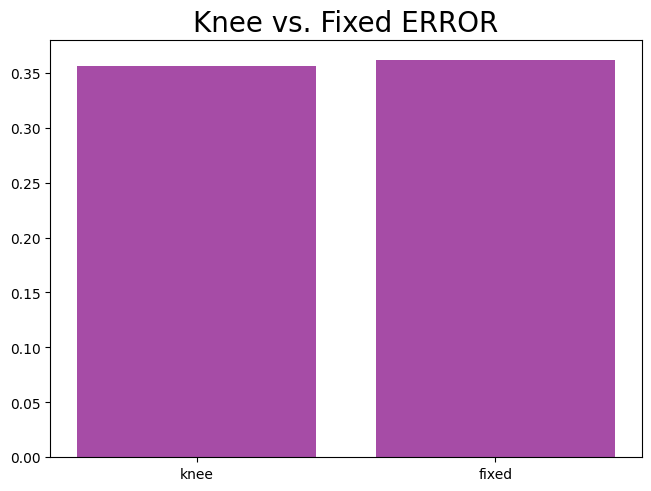

In [113]:
plt.bar(['knee', 'fixed'], [knee['error'].mean(), fixed['error'].mean()], color='purple', alpha=0.7)
plt.title('Knee vs. Fixed ERROR')

Text(0.5, 1.0, 'Knee vs. Fixed R_SQUARED')

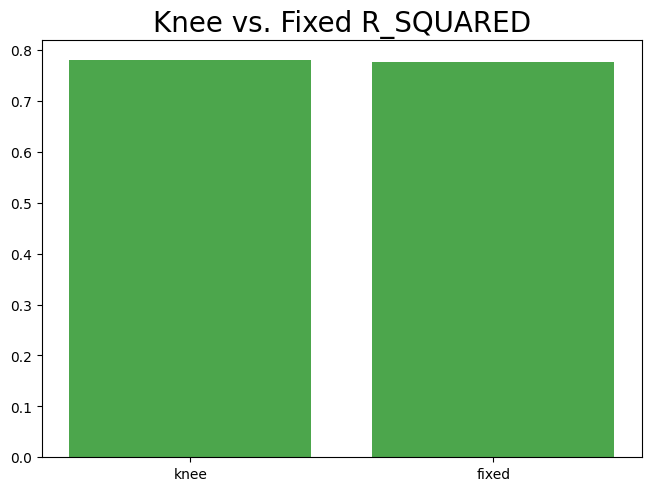

In [114]:
plt.bar(['knee', 'fixed'], [knee['r_squared'].mean(), fixed['r_squared'].mean()], color='green', alpha=0.7)
plt.title('Knee vs. Fixed R_SQUARED')